# 3.8 타이타닉 생존율 예측

##3.8.1 문제 정의

In [25]:
import tensorflow as tf
import keras

## 3.8.2 다양한 형태로 데이터 구성 및 준비하기

In [2]:
import pandas as pd

URL = 'https://storage.googleapis.com/tf-datasets/titanic/train.csv'
df = pd.read_csv(URL)

type(df)

pandas.core.frame.DataFrame

In [3]:
print(df.shape)

df.head()

(627, 10)


,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [4]:
import tensorflow_datasets as tfds

tfds.list_builders()[:5]

['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset']

In [5]:
import tensorflow_datasets as tfds

ds, info = tfds.load('titanic', split='train', with_info=True)

type(ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [6]:
info

tfds.core.DatasetInfo(
    name='titanic',
    full_name='titanic/4.0.0',
    description="""
    Dataset describing the survival status of individual passengers on the Titanic.
    Missing values in the original dataset are represented using ?. Float and int
    missing values are replaced with -1, string missing values are replaced with
    'Unknown'.
    """,
    homepage='https://www.openml.org/d/40945',
    data_dir='C:\\Users\\myngmyng\\tensorflow_datasets\\titanic\\4.0.0',
    file_format=tfrecord,
    download_size=114.98 KiB,
    dataset_size=382.58 KiB,
    features=FeaturesDict({
        'age': float32,
        'boat': string,
        'body': int32,
        'cabin': string,
        'embarked': ClassLabel(shape=(), dtype=int64, num_classes=4),
        'fare': float32,
        'home.dest': string,
        'name': string,
        'parch': int32,
        'pclass': ClassLabel(shape=(), dtype=int64, num_classes=3),
        'sex': ClassLabel(shape=(), dtype=int64, num_classes=2),
 

In [7]:
tfds.as_dataframe(ds.take(4), info)

,age,boat,body,cabin,embarked,fare,home.dest,name,parch,pclass,sex,sibsp,survived,ticket
0,30.0,b'Unknown',-1,b'Unknown',2 (Southampton),13.0,"b'Sarnia, ON'","b'McCrie, Mr. James Matthew'",0,1 (2nd_class),0 (male),0,0 (died),b'233478'
1,37.0,b'Unknown',98,b'Unknown',2 (Southampton),7.925000190734863,"b'Ruotsinphytaa, Finland New York, NY'","b'Gustafsson, Mr. Anders Vilhelm'",0,2 (3rd_class),0 (male),2,0 (died),b'3101276'
2,28.0,b'9',-1,b'Unknown',2 (Southampton),13.0,b'Spain',"b'Reynaldo, Ms. Encarnacion'",0,1 (2nd_class),1 (female),0,1 (survived),b'230434'
3,18.0,b'Unknown',-1,b'Unknown',2 (Southampton),73.5,"b'Lyndhurst, England'","b'Davies, Mr. Charles Henry'",0,1 (2nd_class),0 (male),0,0 (died),b'S.O.C. 14879'


## 3.8.3 모델에서 활용할 수 있도록 데이터 전처리

In [8]:
import pandas as pd

url = 'https://storage.googleapis.com/tf-datasets/titanic/train.csv'
df = pd.read_csv(url)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   survived            627 non-null    int64  
 1   sex                 627 non-null    object 
 2   age                 627 non-null    float64
 3   n_siblings_spouses  627 non-null    int64  
 4   parch               627 non-null    int64  
 5   fare                627 non-null    float64
 6   class               627 non-null    object 
 7   deck                627 non-null    object 
 8   embark_town         627 non-null    object 
 9   alone               627 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 49.1+ KB


<Axes: >

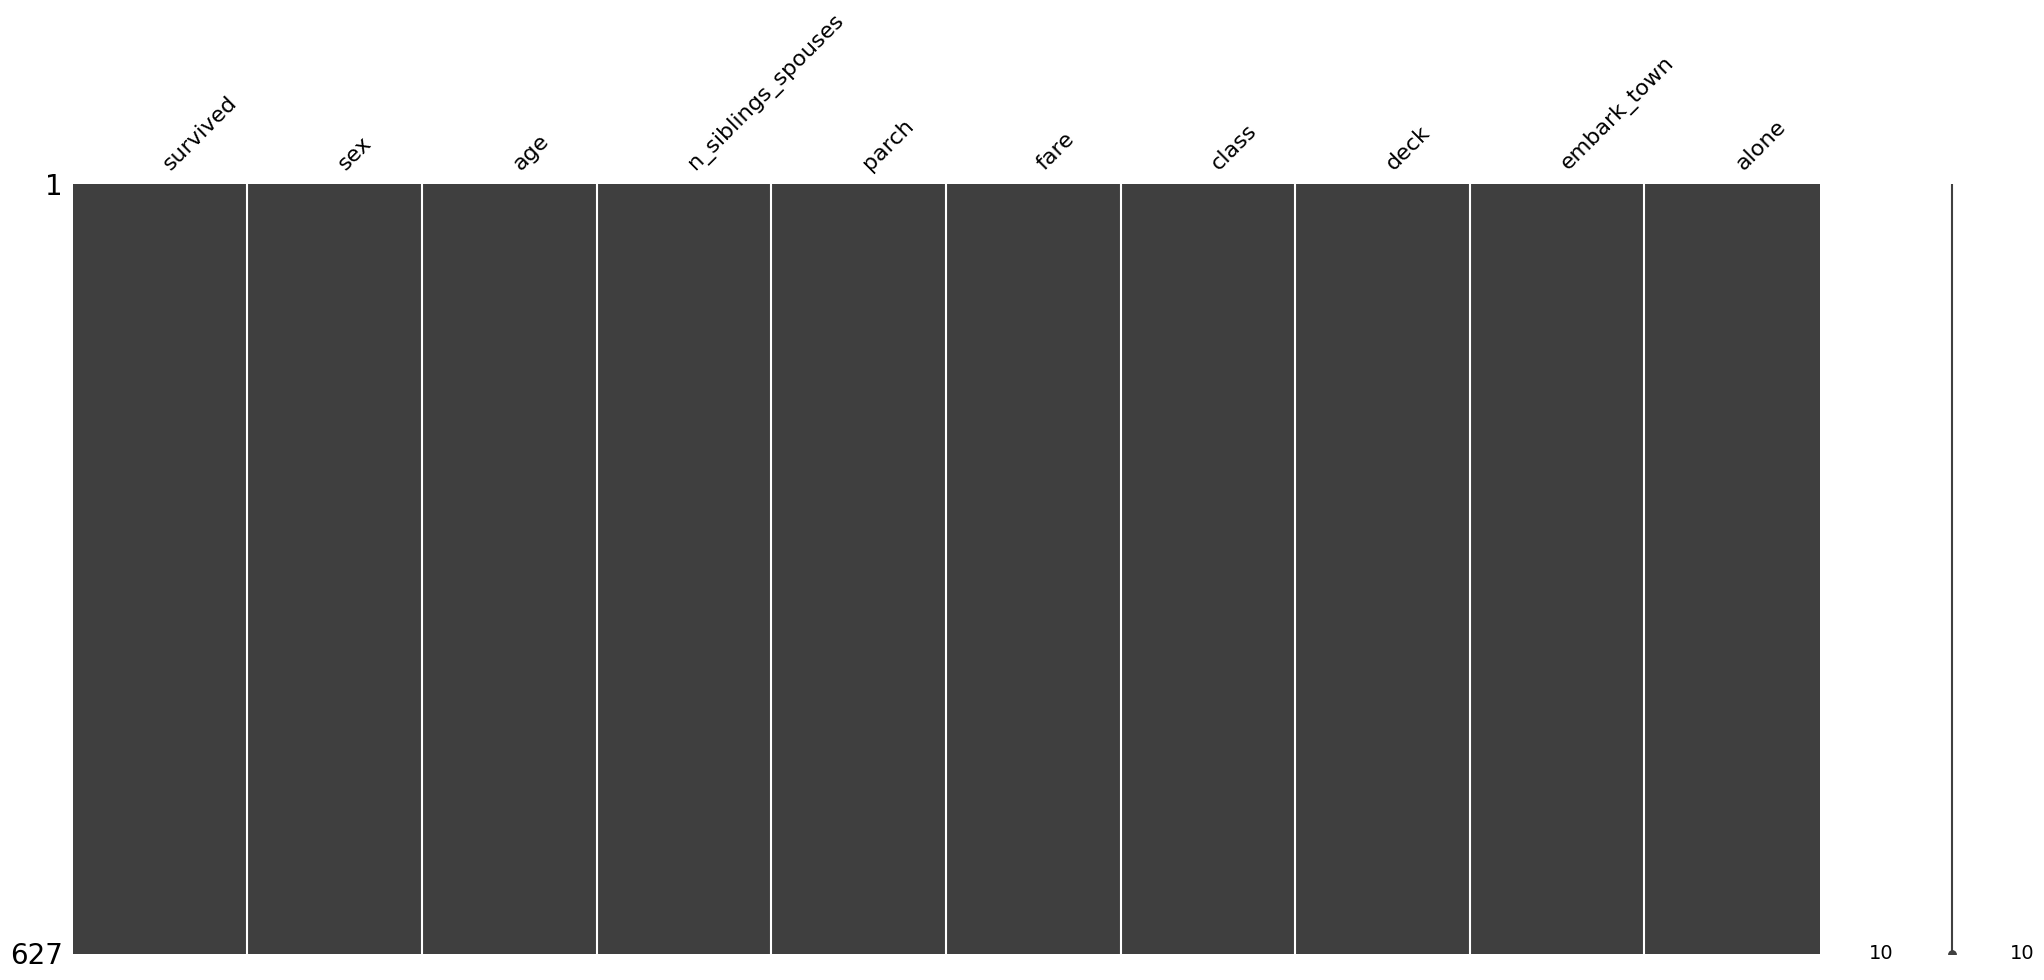

In [9]:
import missingno

missingno.matrix(df)

In [10]:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# le = df[['sex', 'class', 'deck', 'embark_town','alone']].apply(le.fit_transform)

# df['sex'] = le['sex']
# df['class'] = le['class']
# df['deck'] = le['deck']
# df['embark_town'] = le['embark_town']
# df['alone'] = le['alone']

# df.head()
# -----------------------------------------

# 여러개의 컬럼인 경우 OrdinalEncoder 권장
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
col_names = ["sex", "class", "deck", "embark_town", "alone"]
oe = OrdinalEncoder()
df[col_names] = oe.fit_transform(df[col_names]).astype(np.int32)

df.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,1,22.0,1,0,7.2500,2,7,2,0
1,1,0,38.0,1,0,71.2833,0,2,0,0
2,1,0,26.0,0,0,7.9250,2,7,2,1
3,1,0,35.0,1,0,53.1000,0,2,2,0
4,0,1,28.0,0,0,8.4583,2,7,1,1


In [11]:
df_y = df.pop('survived')
df_x = df.loc[:,['age','fare']].copy()

In [12]:
df_y

0      0
1      1
2      1
3      1
4      0
      ..
622    0
623    0
624    1
625    0
626    0
Name: survived, Length: 627, dtype: int64

In [13]:
df_x.T

,0,1,2,3,4,5,6,7,8,9,...,617,618,619,620,621,622,623,624,625,626
age,22.00,38.0000,26.000,35.0,28.0000,2.000,27.0000,14.0000,4.0,20.00,...,15.000,20.0000,19.0000,28.0000,22.0000,28.0,25.00,19.0,28.00,32.00
fare,7.25,71.2833,7.925,53.1,8.4583,21.075,11.1333,30.0708,16.7,8.05,...,7.225,9.8458,7.8958,7.8958,10.5167,10.5,7.05,30.0,23.45,7.75


In [14]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2)

print('train dataset :', x_train.shape, y_train.shape)
print('test dataset :', x_test.shape, y_test.shape)

train dataset : (501, 2) (501,)
test dataset : (126, 2) (126,)


## 3.8.4 다양한 레이어로 순차적인 모델 빌드


In [15]:
import keras
model = keras.Sequential()
model.add(keras.layers.Input(shape=(2,)))
model.add(keras.layers.Dense(32, activation="relu"))
model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

## 3.8.5 이진 분류에 대한 모델 컴파일

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## 3.8.6 모델을 활용하여 학습 및 예측

In [17]:
history = model.fit(x_train, y_train,
          validation_split=0.2,
          batch_size = 1, # 기본값 32
          epochs=5)

Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7066 - loss: 0.7128 - val_accuracy: 0.5446 - val_loss: 0.7121
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5730 - loss: 0.6850 - val_accuracy: 0.5446 - val_loss: 0.8149
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6416 - loss: 0.7165 - val_accuracy: 0.6733 - val_loss: 0.6736
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6341 - loss: 0.7322 - val_accuracy: 0.6436 - val_loss: 0.6249
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6526 - loss: 0.6601 - val_accuracy: 0.6733 - val_loss: 0.6504


In [18]:
loss, accuracy = model.evaluate(x_test, y_test)

print('test accuracy :', accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6517 - loss: 0.7553  
test accuracy : 0.6111111044883728


In [19]:
from sklearn.model_selection import train_test_split

df_x = df.copy()
df_y = df_y.copy()

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2)

print('train dataset :', x_train.shape, y_train.shape)
print('test dataset :', x_test.shape, y_test.shape)

train dataset : (501, 9) (501,)
test dataset : (126, 9) (126,)


In [20]:
import keras

model = keras.Sequential()
model.add(keras.layers.Input(shape=(9,)))
model.add(keras.layers.Dense(32, activation="relu"))
model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

callback_EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = model.fit(x_train, y_train,
          validation_split=0.2,
          batch_size = 16, # 기본값 32
          epochs=100,
          callbacks=callback_EarlyStopping)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6111 - loss: 1.4997 - val_accuracy: 0.6337 - val_loss: 0.6813
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6829 - loss: 0.6767 - val_accuracy: 0.6238 - val_loss: 0.6698
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7110 - loss: 0.5948 - val_accuracy: 0.6832 - val_loss: 0.6266
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6500 - loss: 0.6231 - val_accuracy: 0.6337 - val_loss: 0.6533
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7031 - loss: 0.5821 - val_accuracy: 0.6634 - val_loss: 0.6505
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6793 - loss: 0.5946 - val_accuracy: 0.5743 - val_loss: 0.6964
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7037 - loss: 0.5948 - val_accuracy: 0.5347 - val_loss: 0.8823
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6275 - loss: 0.6734 - val_accuracy: 0.5842 - v

In [21]:
loss, accuracy = model.evaluate(x_test, y_test)

print('test accuracy :', accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7304 - loss: 0.5302 
test accuracy : 0.6984127163887024


In [22]:
y_test.head()

19     0
110    0
394    0
217    0
525    1
Name: survived, dtype: int64

In [23]:
predictions = model.predict(x_test)

print("predictions:", predictions[0:5], sep="\n")
print('y_test:', y_test.head(5), sep="\n")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predictions:
[[0.15714468]
 [0.37060094]
 [0.3671306 ]
 [0.15044786]
 [0.39149582]]
y_test:
19     0
110    0
394    0
217    0
525    1
Name: survived, dtype: int64


## 3.8.7 훈련된 모델의 플롯 손실 및 정확도

In [24]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(specs=[[{"secondary_y": True}]])

# model history
epoch = history.epoch

loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Scatter
fig.add_trace(go.Scatter(x=epoch, y=loss, name="loss"),secondary_y=False,)
fig.add_trace(go.Scatter(x=epoch, y=val_loss, name="val_loss"),secondary_y=False,)
fig.add_trace(go.Scatter(x=epoch, y=accuracy, name="accuracy"),secondary_y=True,)
fig.add_trace(go.Scatter(x=epoch, y=val_accuracy, name="val_accuracy"),secondary_y=True,)

# Templates configuration, Default template: 'plotly'
# Available templates: ['ggplot2', 'seaborn', 'simple_white', 'plotly','plotly_white', 
#                       'plotly_dark', 'presentation', 'xgridoff','ygridoff', 'gridon', 'none']
fig.update_layout(title_text="<b>Loss/Accuracy of Model</b>", template='plotly')

fig.update_xaxes(title_text="Epoch")
fig.update_yaxes(title_text="Loss", secondary_y=False)
fig.update_yaxes(title_text="Accuracy", secondary_y=True)

fig.show()